## Prerequisites to run:
- clone https://github.com/crowdbotp/OpenTraj into the current folder

In [1]:
import os, yaml
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np

In [117]:
np.random.seed(42)

# Tests with OpenTraj Edinburgh dataset
https://github.com/crowdbotp/OpenTraj/tree/master/datasets/Edinburgh

In [32]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=9)

/Users/kriis/ut/MSc/trajectory-forecasting/OpenTraj/opentraj/toolkit/loaders/loader_edinburgh.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(file, sep="\n|=", header=None,index_col=None)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|██████████| 2342/2342 [01:53<00:00, 20.56it/s]


Warning! too big dt in [Edinburgh]
finish


## Dataset overview

In [33]:
data = traj_dataset.data

In [34]:
data.head()

,index,frame_id,agent_id,pos_x,pos_y,scene_id,label,timestamp,vel_x,vel_y
0,3,1359,0,15.368714,10.363272,01Sep,pedestrian,151.0,-0.937357,-0.101301
1,12,1368,0,14.431357,10.261971,01Sep,pedestrian,152.0,-0.937357,-0.101301
2,21,1377,0,13.215721,9.975478,01Sep,pedestrian,153.0,-1.215636,-0.286493
3,30,1386,0,11.819775,9.498739,01Sep,pedestrian,154.0,-1.395946,-0.476739
4,38,1395,0,10.564136,8.865100,01Sep,pedestrian,155.0,-1.255639,-0.633639


In [6]:
max(data["agent_id"])

2341

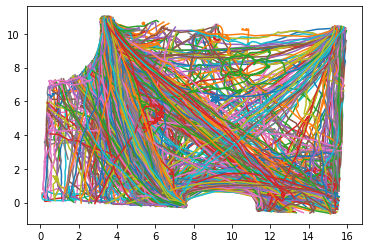

In [7]:
for i in range(1000):
    plt.plot(data.loc[data["agent_id"]==i, ["pos_x"]],data.loc[data["agent_id"]==i, ["pos_y"]])
plt.show()

### Helper functions

In [8]:
# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y

def generate_velocity_data(data, begin_idx, agent_id, num_steps=5):
    sample_vel_x = data["vel_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_vel_y = data["vel_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    
    test_vel_x = data["vel_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_vel_y = data["vel_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_vel_x, sample_vel_y, test_vel_x, test_vel_y

def plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y):
    plt.axes().set_aspect('equal')
        
    plt.plot(np.append(sample_x, pred_x), np.append(sample_y, pred_y), label="fitted polynomial", color='r')
    plt.plot(np.append(sample_x, test_x), np.append(sample_y,test_y), label="actual data", color='b')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    plt.scatter(sample_x[-1], sample_y[-1], color='gray')
    plt.scatter(pred_x[0], pred_y[0], color='r')

    # Comment out the following if you want to see all generated trajectories
    #for i in range(len(pred_x_list)):
    #    plt.plot(np.append(sample_x,pred_x_list[i]), np.append(sample_y,pred_y_list[i]), label="fitted polynomial")

    #plt.legend()
    plt.show()
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Data preprocessing

In [28]:
NUM_OF_STEPS = 5

In [40]:
# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

## Polynomial model
### Method of generating n (5) trajectories and averaging them as a prediction

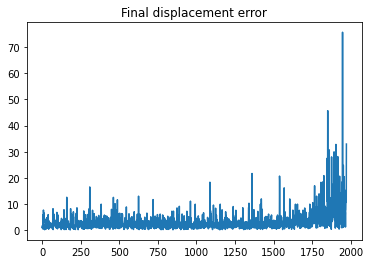

Average FDE:  3.140160058905686


In [26]:
def n_trajectory_average(data, agent_id, step, num_of_trajectories=5, noise=0.05, plot_data=False):
    # Generate 'seen' and 'unseen' data
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, step)
    
    # Generate a certain number of trajectories with noise
    pred_x_list = []
    pred_y_list = []
    for i in range(num_of_trajectories):
        noisy_sample_x = sample_x + np.random.normal(0,noise,len(sample_x))
        noisy_sample_y = sample_y + np.random.normal(0,noise,len(sample_y))
        
        # Fit a polynomial function to the data
        time_range = range(len(sample_x))
        fitted_x = np.polyfit(time_range, noisy_sample_x, 2)
        fitted_y = np.polyfit(time_range, noisy_sample_y, 2)

        time_range_pred = range(len(sample_x), 2*len(sample_x))
        pred_x = np.polyval(fitted_x, time_range_pred)
        pred_y = np.polyval(fitted_y, time_range_pred)
        
        pred_x_list.append(pred_x)
        pred_y_list.append(pred_y)
        
    # Calculate the final prediction by finding the mean of the noisy trajectories
    avg_pred_x = np.mean(pred_x_list, axis=0)
    avg_pred_y = np.mean(pred_y_list, axis=0)
    
    if (plot_data):
        plot_predictions(sample_x, sample_y, test_x, test_y, avg_pred_x, avg_pred_y)
    
    # Error calculation
    FDE, MSE = calculate_error(pred_x, pred_y, test_x, test_y)
    return FDE, MSE

step = 5
all_FDE = []
for i in agent_ids:
    run_FDE, run_MSE = n_trajectory_average(data, agent_id=i, step=step)
    all_FDE.append(run_FDE)


plt.plot(all_FDE)
plt.title("Final displacement error")
plt.show()

print("Average FDE: ", np.mean(all_FDE))

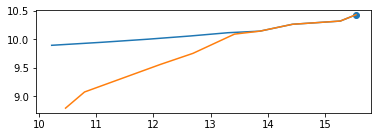

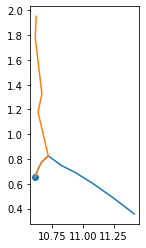

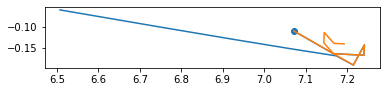

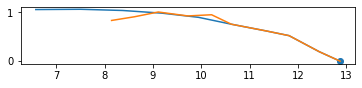

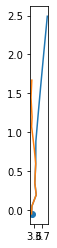

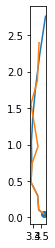

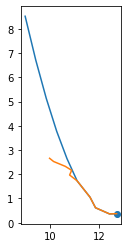

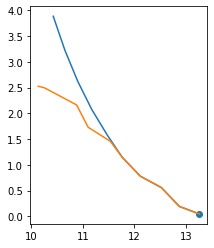

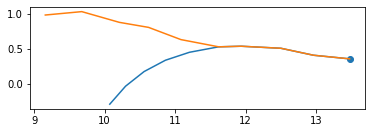

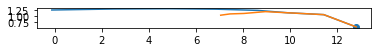

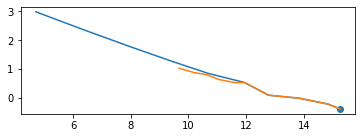

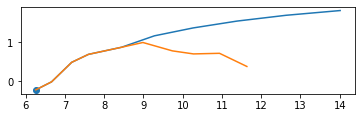

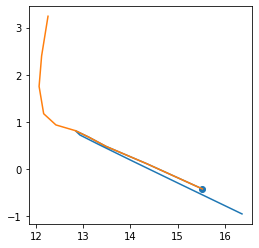

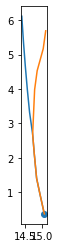

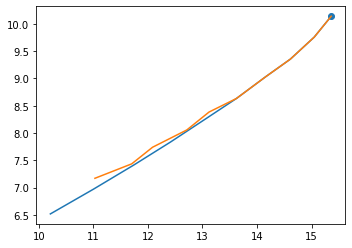

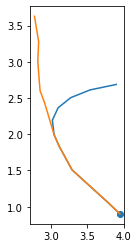

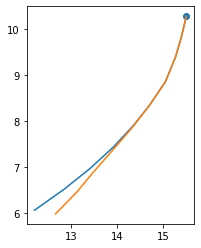

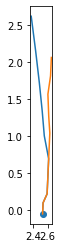

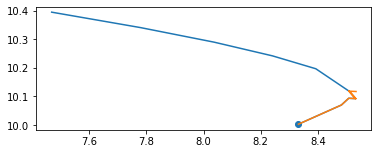

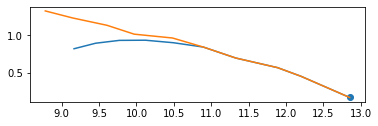

In [114]:
# Checking some plot examples
for i in agent_ids[:20]:
    run_rmse = n_trajectory_average(data, agent_id=i, step=step, plot_data=True)

### Experiment to see what effect the noise level has

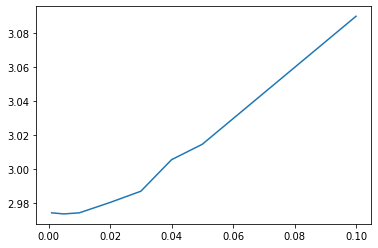

In [125]:
step = 5
noise_levels = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

noise_FDE = []
for noise in noise_levels:
    all_FDE = []
    for i in agent_ids:
        run_FDE, run_MSE = n_trajectory_average(data, agent_id=i, noise=noise, step=step)
        all_FDE.append(run_FDE)
    noise_FDE.append(np.mean(all_FDE))

plt.plot(noise_levels, noise_FDE)

### Method generating n trajectories, removing 2 furthest and averaging the rest as a prediction

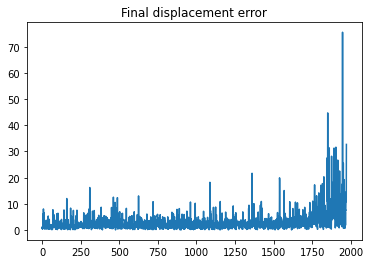

Average FDE:  3.0337642679661534


In [27]:
def n_trajectory_average_w_remove_furthest(data, agent_id, step, num_of_trajectories=5, plot_data=False):
    # Generate 'seen' and 'unseen' data
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, step)
    
    # Generate a certain number of trajectories with noise
    pred_x_list = []
    pred_y_list = []
    for i in range(num_of_trajectories):
        noisy_sample_x = sample_x + np.random.normal(0,0.05,len(sample_x))
        noisy_sample_y = sample_y + np.random.normal(0,0.05,len(sample_y))
        
        # Fit a polynomial function to the data
        time_range = range(len(sample_x))
        fitted_x = np.polyfit(time_range, noisy_sample_x, 2)
        fitted_y = np.polyfit(time_range, noisy_sample_y, 2)

        time_range_pred = range(len(sample_x), 2*len(sample_x))
        pred_x = np.polyval(fitted_x, time_range_pred)
        pred_y = np.polyval(fitted_y, time_range_pred)
        
        pred_x_list.append(pred_x)
        pred_y_list.append(pred_y)
        
    # Find the mean trajectory
    avg_pred_x = np.mean(pred_x_list, axis=0)
    avg_pred_y = np.mean(pred_y_list, axis=0)
    
    
    # Find two furthermost trajectories from the mean
    rmse_sums_from_avg = []
    for i in range(len(pred_x_list)):
        abs_error_x = pred_x_list[i] - avg_pred_x
        abs_error_y = pred_y_list[i] - avg_pred_y

        RMSE_x = np.sqrt(np.mean(np.square(abs_error_x)))
        RMSE_y = np.sqrt(np.mean(np.square(abs_error_y)))
        
        rmse_sums_from_avg.append(RMSE_x + RMSE_y)
        
    # Remove the furthermost trajectories
    for i in range(2):
        val, idx = max((val, idx) for (idx, val) in enumerate(rmse_sums_from_avg))
        
        del pred_x_list[idx]
        del pred_y_list[idx]
        del rmse_sums_from_avg[idx]
    
    # Calculate the final prediction by finding the mean of the remaining trajectories
    final_pred_x = np.mean(pred_x_list, axis=0)
    final_pred_y = np.mean(pred_y_list, axis=0)
    
    if (plot_data):
        plot_predictions(sample_x, sample_y, test_x, test_y, final_pred_x, final_pred_y)
    
    # Error calculation
    FDE, MSE = calculate_error(final_pred_x, final_pred_y, test_x, test_y)
    return FDE, MSE

step = 5
all_FDE = []
for i in agent_ids:
    run_FDE, run_MSE = n_trajectory_average_w_remove_furthest(data, agent_id=i, step=step)
    all_FDE.append(run_FDE)


plt.plot(all_FDE)
plt.title("Final displacement error")
plt.show()

print("Average FDE: ", np.mean(all_FDE))

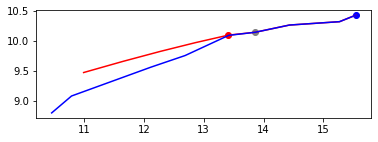

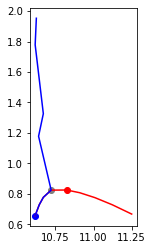

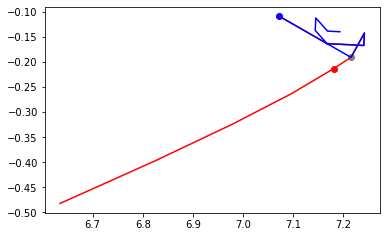

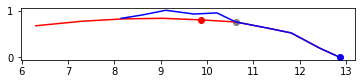

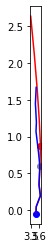

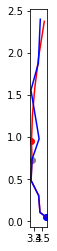

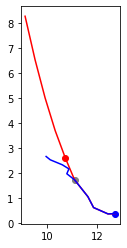

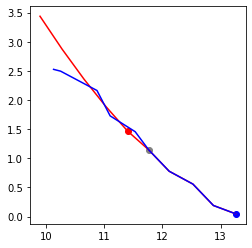

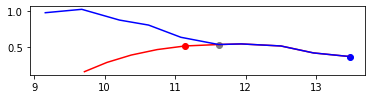

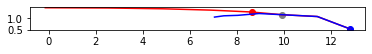

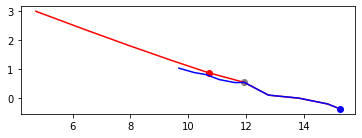

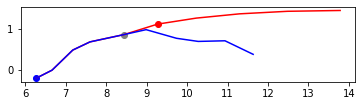

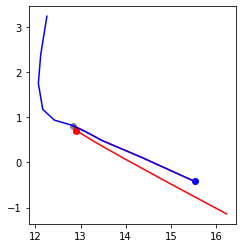

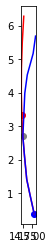

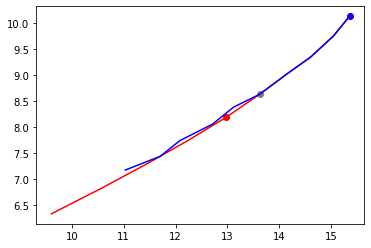

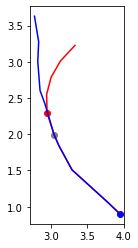

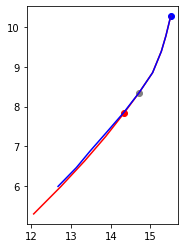

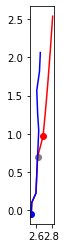

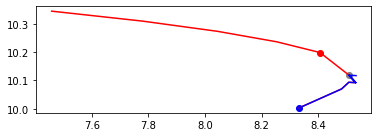

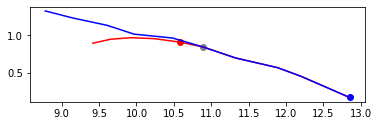

In [28]:
# Checking some plot examples
for i in agent_ids[:20]:
    run_rmse = n_trajectory_average_w_remove_furthest(data, agent_id=i, step=step, plot_data=True)